#### Setup

In [ ]:
! pip install wand
! brew uninstall imagemagick
! brew install imagemagick@6
! brew unlink imagemagick
! brew link imagemagick@6 --force
! echo 'export MAGICK_HOME="/usr/local/opt/imagemagick@6/lib"' >> ~/.bash_profile
! echo 'export PATH="/usr/local/opt/imagemagick@6/bin:$PATH"' >> ~/.bash_profile

! source ~/.bash_profile

## Font Generation

In [1]:
import os
import numpy as np
import cv2
from tqdm import tqdm
from wand.color import Color
from wand.image import Image
from wand.drawing import Drawing
from wand.compat import nested
import shutil
import pandas as pd

In [2]:
# Characters 
language = 'abcdefghijklmnopqrstuvwxyz'
language_upper = language.upper()
language += language_upper
language += '0123456789'

assert len(language) == 26 * 2 + 10 
language = language_upper
language

'ABCDEFGHIJKLMNOPQRSTUVWXYZ'

In [3]:
handwritten_fonts = ['Herculanum', 'Annai MN', 'Bradley Hand', 'Brush Script MT', 'Chalkboard',
             'Comic Sans MS', 'Luminary', 'Noteworthy', 'Papyrus', 'Party LET', 'Savoye LET', 
             'Sign Painter', 'Skia', 'Snell Roundhand', 'Times New Roman', 'Trattatello']
typed_fonts = ['Arial', 'Arial Black', 'Arial Narrow', 'Arial Rounded MT Bold', 'Copperplate', 'Courier New', 'Helvetica',
              'Impact', 'Lucinda Grande', 'Microsoft Sans Serif', 'Tahoma', 'Verdana', 'Menlo', 'Didot', 'Copperplate', 'Avenir', 'Futura']

fonts = handwritten_fonts + typed_fonts 

In [4]:
# resolution
width=200
height=200
font_size=100
background = Color('white')
foreground=Color('rgb(0, 0, 0)')

In [5]:
def delete(language, language_upper):
    for c in language:
        if c in language_upper:
            if os.path.exists(f'{c}{c}'):
                shutil.rmtree(f'{c}{c}')
        else:
            if os.path.exists(c):
                shutil.rmtree(f'{c}')
                
def generate(fonts, language, language_upper, width=200, height=200, font_size=100, background=Color('white'), foreground=Color('rgb(0,0,0)')):
    for f in tqdm(fonts):
        for c in language:
            if c in language_upper:
                if not os.path.exists(f'{c}{c}'):
                    os.mkdir(f'{c}{c}')
                filename = os.path.join(f'{c}{c}', f'{f}.png')
            else:
                if not os.path.exists(c):
                    os.mkdir(f'{c}')
                filename = os.path.join(f'{c}', f'{f}.png')

            with Drawing() as draw:
                with Image(width=width, height=height, background=background) as img:
                    draw.font_family = f
                    draw.font_size = font_size
                    draw.push()
                    draw.fill_color = foreground
                    draw.text(0,int(img.height/2), c)
                    draw.pop()
                    draw(img)
                    if os.path.exists(filename):
                        os.unlink(filename)
                    img.save(filename='tmp.png')

                    img = cv2.imread('tmp.png')

                    os.unlink('tmp.png')
                    ys, xs = np.where(np.all(img == (0, 0, 0), axis=-1))
                    
                    if len(ys) > 0 and len(xs) > 0:
                        cropped = img[min(ys):max(ys)+1, min(xs):max(xs)+1]
                        cv2.imwrite(filename, cropped)


In [6]:
generate(fonts, language, language_upper)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 33/33 [00:04<00:00,  7.28it/s]


## Pipeline

In [7]:
import matplotlib.pyplot as plt
def show(*img):
    for i in img:
        plt.imshow(i, cmap='gray')
        plt.axis('off')
        plt.show()
        
def show_rgb(*img):
    for i in img:
        plt.imshow(i, cmap='gray')
        plt.show()

def read(path):
    return cv2.imread(path, cv2.IMREAD_GRAYSCALE)

def read_rgb(path):
    return cv2.imread(path, cv2.IMREAD_UNCHANGED)

def bin(img, bins=10, min_diff=10):
    count, division = np.histogram(img, bins)
    diff_series = pd.Series(count).diff()
    
    first_histogram_reduction_index = diff_series[(diff_series < 0) & (np.abs(diff_series) > min_diff)].index[0]
    threshold = division[first_histogram_reduction_index+1]
        
    _, img = cv2.threshold(img,threshold,255,cv2.THRESH_BINARY)
    return img

def bin_simple(img, thresh=127):
    img[img >= thresh] = 255
    img[img <= thresh] = 0
    return img
    
def bin2(img):
    return cv2.threshold(img, 0, 255, cv2.THRESH_BINARY +cv2.THRESH_OTSU)[1]

def neg(img):
    return 255 - img

def redraw_contours(img, thickness=16): 
    # Find contours and redraw
    contours, hierarchy = cv2.findContours(image=img, mode=cv2.RETR_TREE, method=cv2.CHAIN_APPROX_NONE)
                                      
    # draw contours on the original image
    image_copy = img.copy()
    cv2.drawContours(image=image_copy, contours=contours, contourIdx=-1, color=(255, 255, 255), thickness=thickness, lineType=cv2.LINE_AA)
    return image_copy

def components(img, min_area=600, show_steps=False):
    # Connected components
    output = cv2.connectedComponentsWithStats(img, 4, cv2.CV_32S)
    num_letters = output[0]
    labels = output[1]
    stats = output[2]
    centroids = output[3]

    letter_imgs = []
    img_components = img.copy()
    ## Sort letters + area check
    for l in range(1, num_letters):
        minx = stats[l, cv2.CC_STAT_LEFT]
        maxx = stats[l, cv2.CC_STAT_WIDTH] + minx
        miny = stats[l, cv2.CC_STAT_TOP] 
        maxy = stats[l, cv2.CC_STAT_HEIGHT] + miny
        area = stats[l, cv2.CC_STAT_AREA]
        if area < min_area:
            continue

        img_copy = img.copy()
        img_copy[labels != l] = 0
        img_copy[labels == l] = 255
        cropped_img = img_copy[miny:maxy+1, minx: maxx+1].copy()
        if show_steps:
            start_point = (minx, miny)
            end_point = (maxx, maxy)
            color = (255, 255, 255)
            thickness = 3
            img_components = cv2.rectangle(img_components, start_point, end_point, color, thickness)
        
        # Add negatives directly 
        letter_imgs.append((neg(cropped_img), minx, maxx, miny, maxy))
        
    # Show found components boxes
    if show_steps:
        show(img_components)
    
    # Detect spaces and newlines
    sorted_imgs_y = sorted(letter_imgs, 
       key=lambda x: x[3])

    rectangles = sorted_imgs_y.copy()
    
    from collections import defaultdict
    rows = defaultdict(list)
    row_id = 0
    while len(rectangles) > 0:
        r = rectangles[0]
        rows[row_id].append(r)
        ctr_y = (r[3] + r[4])/2
        rectangles.remove(r)
        
        to_remove = []
        for (img, minx, maxx, miny, maxy) in rectangles:
            # if central y line goes through letter box
            if ctr_y >= miny and ctr_y <= maxy:
                rows[row_id].append((img, minx, maxx, miny, maxy))
                to_remove.append((img, minx, maxx, miny, maxy))
        
        for rem in to_remove:
            rectangles.remove(rem)
            
        row_id+=1
    
    final_result = []
    # for y in text
    for row in range(row_id):
        line = []
        # Search for spaces
        sorted_imgs_x = sorted(rows[row], 
           key=lambda x: x[1])
        
        # for char in line
        word = []
        for i in range(0, len(sorted_imgs_x)-1):
            xmax_first = sorted_imgs_x[i][2]
            xmin_second = sorted_imgs_x[i+1][1]

            prev_letter_width = sorted_imgs_x[i][2] - sorted_imgs_x[i][1]
            next_letter_width = sorted_imgs_x[i+1][2] - sorted_imgs_x[i+1][1]
            dist = (xmin_second - xmax_first)
            
            word.append(sorted_imgs_x[i])
            if dist >= max(prev_letter_width, next_letter_width):
                line.append(word)
                word = []
        
        # Assume no space at end of line
        word.append(sorted_imgs_x[-1])
        line.append(word)
        final_result.append(line)
    
    return final_result

def gray(img):
    return cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

def resize(img, size=(100, 100)):
    return cv2.resize(img, size, interpolation=cv2.INTER_NEAREST)

def erode(img, it=1):
    kernel = np.ones((3, 3), np.uint8)
    return cv2.erode(img, kernel, iterations=it)

def dilate(img, it=1):
    kernel = np.ones((3, 3), np.uint8)
    return cv2.dilate(img, kernel, iterations=it)

def blur(x):
    return cv2.GaussianBlur(x, (3, 3), cv2.BORDER_DEFAULT)

def bin_2(path, show_steps=False):
    x = read(path)
    y = cv2.Laplacian(x, cv2.CV_16S, ksize=3)
    if show_steps:
        show(x)
        show(y)

    # Binarize
    z = y.copy()
    z[z > 127] = 255
    z[z <= 127] = 0
    return z

def pipeline_2(path, show_steps=False, screenshot=False):
    z = bin_2(path, show_steps)
    
    if screenshot:
        thickenings = [1]
    else:
        thickenings = [3]
        
    num_chars = []
    for it in thickenings:
        # Thicken letters
        q = dilate(z, it=it).astype(np.uint8)
        q = erode(z, it=it).astype(np.uint8)
        
        # Find components
        lines = components(q, show_steps=show_steps)
        n_chars = sum([len(w) for line in lines for w in line])
        num_chars.append(n_chars)
    
    max_chars_idx = np.argmax(num_chars)
    it = thickenings[max_chars_idx]
    # Thicken letters
    q = dilate(z, it=it).astype(np.uint8)

    # Find components
    lines = components(q, show_steps=show_steps)

    if show_steps:
        show(z)
        show(q)
        for line in lines:
            for word in line:
                for c in word:
                    show(c[0])
            
    return lines

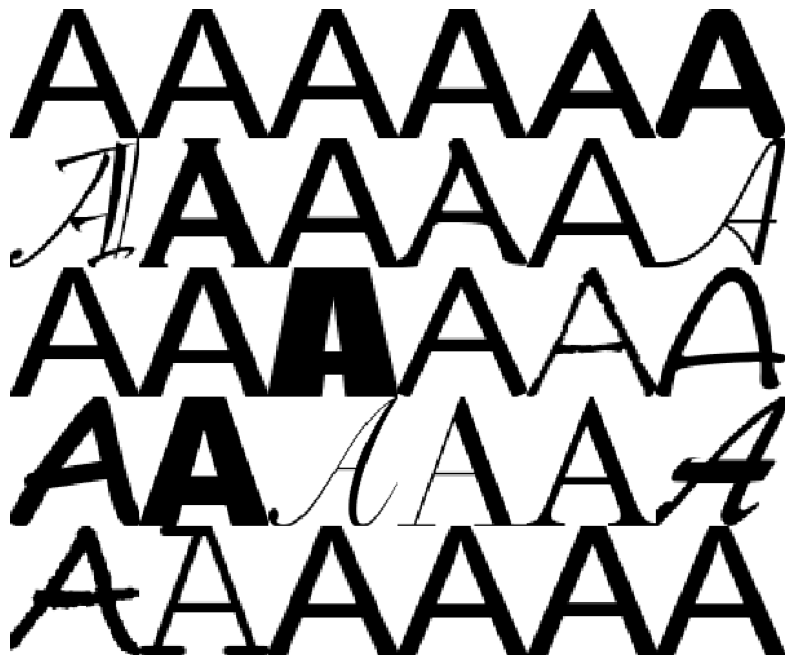

In [68]:
def show_class(character='KK'):
    hstacks = []
    char_images = [resize(read(os.path.join(character, x)), size=(100, 100)) for x in os.listdir(character) if x.endswith('.png')]
    for i in range(5):
        imgs = char_images[i*6:(i+1)*6]
        hstacks.append(np.hstack(imgs))

    plt.figure(figsize=(10, 10))
    show(np.vstack(hstacks))

show_class('AA')

#### Data

In [10]:
import glob

size = 64

image_paths = sorted(glob.glob("*/*.png"))
train_labels = np.array(list(range(26)))
classes = sorted(set([i[:i.index('/')] for i in image_paths]))
classes_fmap = dict(zip(classes, train_labels))
classes_imap = dict(zip(train_labels, classes))

train_images = [resize(read(x), size=(size, size))//255 for x in image_paths]
train_labels = np.stack([classes_fmap[i[:i.index('/')]] for i in image_paths])
train_images = np.stack(train_images)

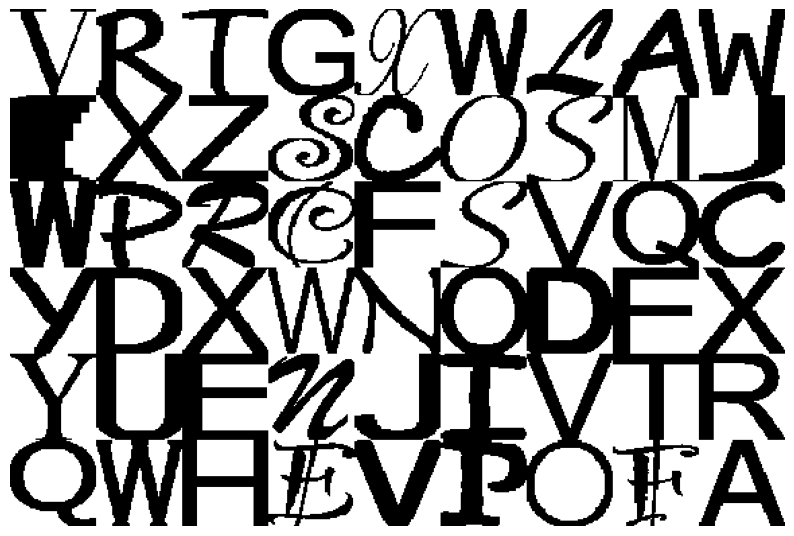

In [11]:
def random_sample(train_images):
    hstacks = []
    np.random.seed(0)
    for _ in range(6):
        idx = np.random.choice(len(train_images), 9)
        sample = train_images[idx]
        hstacks.append(np.hstack(sample))

    plt.figure(figsize=(10, 10))
    show(np.vstack(hstacks))
    
random_sample(train_images)

#### Augmentation

In [12]:
def augment(train_images, train_labels, 
            dilate_depth=1, 
            erode_depth=2,
            r_from=-5,
            r_to=5,
            r_step=5):
    res_images = []
    res_labels = []
    for i in range(train_images.shape[0]):
        img = train_images[i]
        l = train_labels[i]

        # rotation
        # negate for black background
        x = neg(img * 255)
        
        # First, expand the image and translate to center
        new_shape = (int(x.shape[0]*1.43), int(x.shape[1]*1.43))
        tx = (new_shape[0] - x.shape[0])/2
        ty = (new_shape[1] - x.shape[1])/2
        M = np.float32([[1,0,tx],[0,1,ty]])
        dst = cv2.warpAffine(x,M,x.shape)

        translated = cv2.warpAffine(x, M, new_shape)
        
        cx = translated.shape[0]/2
        cy = translated.shape[1]/2
        for d in range(r_from, r_to+1, r_step):
            M = cv2.getRotationMatrix2D((cx, cy),d,1) 
            rotated = cv2.warpAffine(translated, M, (int(x.shape[0]*1.43), int(x.shape[0]*1.43)))
            
            # Reverse negation
            rotated = neg(rotated)
            res_images.append(rotated)
            res_labels.append(l)
                  
            # erosion
            for it in range(1, erode_depth+1):
                rotated_and_eroded = erode(rotated, it=it)
                res_images.append(rotated_and_eroded)
                res_labels.append(l)

            # dilation
            for it in range(1, dilate_depth+1):
                rotated_and_dilated = dilate(rotated, it=it)
                res_images.append(rotated_and_dilated)
                res_labels.append(l)
        
        
    cropped_images = []
    for r in res_images:
        ys, xs = np.where(r==0)

        if len(ys) > 0 and len(xs) > 0:
            cropped = r[min(ys):max(ys)+1, min(xs):max(xs)+1]
            resized = resize(cropped, (size, size))
            if resized.shape[0] > 0:
                cropped_images.append(resized)
        
    return np.stack(cropped_images)//255,np.array(res_labels)  

Total images for training:  17441


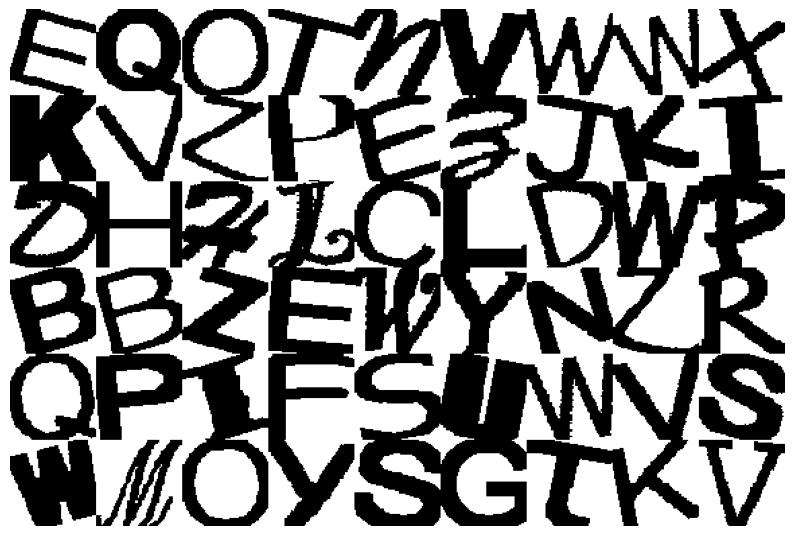

In [13]:
# Augment images 
erode_depth = 1
dilate_depth = 1
r_from = -15
r_to = 16
r_step = 5
train_images_augmented, train_labels_augmented = augment(train_images, train_labels, 
                                                         erode_depth=erode_depth, 
                                                         dilate_depth=dilate_depth,
                                                         r_from=r_from,
                                                         r_to=r_to,
                                                         r_step=r_step)
print('Total images for training: ', len(train_images_augmented))
random_sample(train_images_augmented)

In [24]:
# Test set
val_images = []
val_classes = []
results = {}
tests = {'btv.png': 'BTV',
         'multiline.mpng': 'FMI\nIMAGE\nPROCESSING',
         'multiline-2.mpng': 'TACTICAL\nDIGITAL',
         'mazalo.mpng': 'TOTAL SHTETA\nLESHTA BOB\nMAZZALLO',
        'team.png': 'TEAM',
        'fmi.png': 'FMI',
        'digital.png': 'DIGITAL',
        'tactical.png': 'TACTICAL',
        'ocr.png': 'OCR',
        'test.png': 'TEST',
        'nova.png': 'NOVA',
        'image.png': 'IMAGE',
        'processing.png': 'PROCESSING',
        'trt1.png': 'TEXT\nRECOGNITION\nPROGRAM\nTEXT',
         'vasko.png': 'VASKO THE\nFROG'
        }

for t, label in tests.items():
    char_count = 0
    for line in pipeline_2(t):
        for word in line:
            for c in word:
                cropped_char = c[0]
 
                letter_img_res = bin(resize(cropped_char, (size, size)))//255
                val_images.append(letter_img_res)

                l = f'{label[char_count]}{label[char_count].upper()}'
                clazz = classes_fmap[l]
                val_classes.append(clazz)
                char_count+=1
            char_count+=1 # space should be counted as character

val_images = np.stack(val_images)
val_classes = np.array(val_classes)
len(val_images), len(val_classes)

(150, 150)

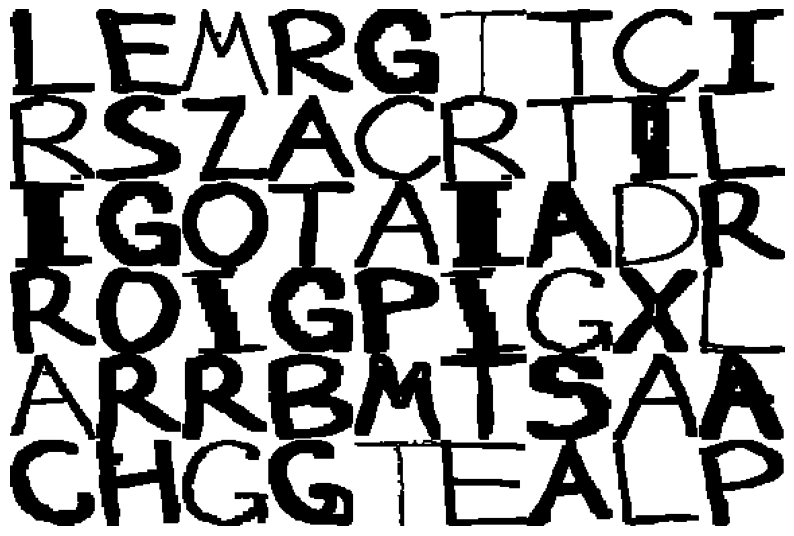

In [25]:
random_sample(val_images)

#### Model

In [30]:
import tensorflow as tf
from tensorflow.keras import datasets, layers, models

tf.keras.utils.set_random_seed(0)

epochs = 15

model = models.Sequential()
model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(size, size, 1)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.Flatten())
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(len(language), activation='softmax'))
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_9 (Conv2D)           (None, 62, 62, 32)        320       
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 31, 31, 32)       0         
 2D)                                                             
                                                                 
 conv2d_10 (Conv2D)          (None, 29, 29, 64)        18496     
                                                                 
 max_pooling2d_7 (MaxPooling  (None, 14, 14, 64)       0         
 2D)                                                             
                                                                 
 conv2d_11 (Conv2D)          (None, 12, 12, 64)        36928     
                                                                 
 flatten_3 (Flatten)         (None, 9216)             

In [31]:
# Shuffle
idx = np.random.permutation(len(train_images_augmented))
train_images_augmented, train_labels_augmented = train_images_augmented[idx], train_labels_augmented[idx]
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
              metrics=['accuracy'])

mcp_save = tf.keras.callbacks.ModelCheckpoint('model_best.h5', save_best_only=True, monitor='val_accuracy', mode='max')
history = model.fit(train_images_augmented, train_labels_augmented, 
                    epochs=epochs, validation_data=(val_images, val_classes), callbacks=[mcp_save])


Epoch 1/15
546/546 [==============================] - 15s 28ms/step - loss: 0.6666 - accuracy: 0.8378 - val_loss: 0.4031 - val_accuracy: 0.8733
Epoch 2/15
546/546 [==============================] - 15s 28ms/step - loss: 0.2238 - accuracy: 0.9491 - val_loss: 0.3108 - val_accuracy: 0.9200
Epoch 3/15
546/546 [==============================] - 15s 28ms/step - loss: 0.1558 - accuracy: 0.9646 - val_loss: 0.3364 - val_accuracy: 0.9333
Epoch 4/15
546/546 [==============================] - 15s 28ms/step - loss: 0.1341 - accuracy: 0.9689 - val_loss: 0.2870 - val_accuracy: 0.9333
Epoch 5/15
546/546 [==============================] - 16s 29ms/step - loss: 0.1169 - accuracy: 0.9731 - val_loss: 0.3430 - val_accuracy: 0.9000
Epoch 6/15
546/546 [==============================] - 16s 29ms/step - loss: 0.1114 - accuracy: 0.9731 - val_loss: 0.3217 - val_accuracy: 0.9067
Epoch 7/15
546/546 [==============================] - 16s 29ms/step - loss: 0.1007 - accuracy: 0.9749 - val_loss: 0.3343 - val_accuracy:

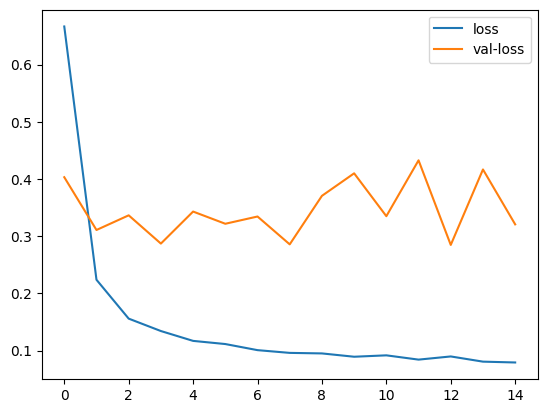

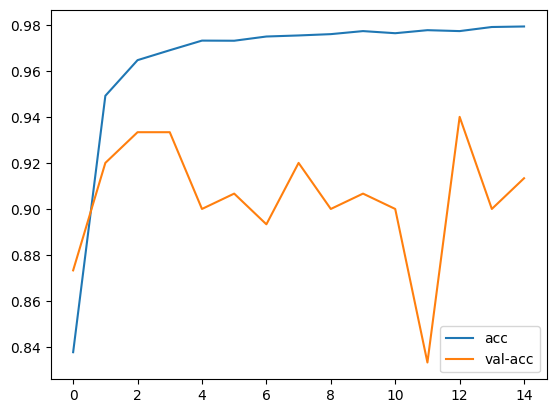

In [32]:
pd.Series(history.history['loss']).plot()
pd.Series(history.history['val_loss']).plot()
plt.legend(['loss', 'val-loss'])
plt.show()
pd.Series(history.history['accuracy']).plot()
pd.Series(history.history['val_accuracy']).plot()
plt.legend(['acc', 'val-acc'])


In [33]:
model = tf.keras.models.load_model('model_best.h5')

In [34]:
def classify_nn_augmented(letter_img, inference_size=(size, size), _filter='.png'):
    # Add dilation to inference
    cx = letter_img.shape[0]/2
    cy = letter_img.shape[1]/2
    all_imgs = []
    all_imgs.append(letter_img)
    for d in range(r_from, r_to, r_step):
        M = cv2.getRotationMatrix2D((cx, cy),d,1) 
        rotate = neg(cv2.warpAffine(neg(letter_img),M, x.shape))
        all_imgs += [dilate(rotate, it=i) for i in range(1, dilate_depth)]
        all_imgs += [erode(rotate, it=i) for i in range(1, erode_depth)]
    
    characters = []
    for i, letter_img in enumerate(all_imgs):
        letter_img_res = bin(resize(letter_img, inference_size))//255
        letter_img_tensor = np.stack([letter_img_res])

        results = model.predict(letter_img_tensor, verbose=False)
        char_idx = np.argmax(results)
        character = classes_imap[char_idx][0]
        characters.append({'char': character, 'dilate_it': i, 'result': np.max(results)})
        
    characters = pd.DataFrame(characters)
    return characters['char'].mode().values[0]

def classify_nn(letter_img, inference_size=(size, size), _filter='.png'):
    letter_img_res = bin(resize(letter_img, inference_size))//255
    letter_img_tensor = np.stack([letter_img_res])
        
    results = model.predict(letter_img_tensor, verbose=False)
    char_idx = np.argmax(results)
    character = classes_imap[char_idx][0]
    return character, results

def ocr(path, show_steps, class_fn):
    lines = pipeline_2(path, show_steps=show_steps)
    text = ''
    for il, line in enumerate(lines):
        for iw, word in enumerate(line):
            for c, *_ in word:
                char = class_fn(c)[0]
                text += char
            if iw != len(line) - 1:
                text += ' '
        if il != len(lines) - 1:
            text += '\n'
    return text

def ocr_nn(path, show_steps=False):
    return ocr(path, show_steps, classify_nn)
    
    
def ocr_nn_augmented(path, show_steps=False):
    return ocr(path, show_steps, classify_nn_augmented)

#### Tests NN

In [36]:
ocr_nn('nova.png', show_steps=False)

'NOVA'

In [37]:
ocr_nn('btv.png', show_steps=False)

'BTV'

In [ ]:
len(tests)

15

In [ ]:
sum([len(x) for x in list(tests.values())])

162

In [57]:
# testsheet
results = {}
fns = [ocr_nn]
tests = {'btv.png': 'BTV',
         'multiline.mpng': 'FMI\nIMAGE\nPROCESSING',
         'multiline-2.mpng': 'TACTICAL\nDIGITAL',
         'mazalo.mpng': 'TOTAL SHTETA\nLESHTA BOB\nMAZZALLO',
        'team.png': 'TEAM',
        'fmi.png': 'FMI',
        'digital.png': 'DIGITAL',
        'tactical.png': 'TACTICAL',
        'ocr.png': 'OCR',
        'test.png': 'TEST',
        'nova.png': 'NOVA',
        'image.png': 'IMAGE',
        'processing.png': 'PROCESSING',
        'trt1.png': 'TEXT\nRECOGNITION\nPROGRAM\nTEXT',
         'vasko.png': 'VASKO THE\nFROG'
        }


errors = []
for fn in fns:
    num_correct = 0
    num_total = 0
    
    for t, label in tests.items():
        num_total += len(label)

        result = ''.join(fn(t))
        
        letter_map = {}
        char_count = 0
        for line in pipeline_2(t):
            for word in line:
                for c in word:
                    cropped_char = c[0]

                    letter_img_res = bin(resize(cropped_char, (size, size)))//255
                    letter_map[char_count] = letter_img_res
                    char_count+=1
                char_count+=1 # space should be counted as character
                
        for i in range(min(len(label), len(result))):
            if label[i] == result[i]:
                num_correct+=1
            else:
                errors.append((i, label[i], result[i], t, letter_map[i]))
        print(t, result)
        
    results[fn] = num_correct/num_total
print('Accuracy:', results)

print('Errors')
for p in errors:
    print(f'Letter with index {p[0]} -> {p[1]} was confused with {p[2]} in {p[3]}')

btv.png BTV
multiline.mpng FMI
INAGE
PROGESSING
multiline-2.mpng TACTICAL
DIGYTAL
mazalo.mpng TOTAL SHTETA
LESHTA BOB
MAZZALLO
team.png TEAM
fmi.png FMI
digital.png DIGITAL
tactical.png TACTICAL
ocr.png OCR
test.png TEST
nova.png NOVA
image.png INAGE
processing.png PROGESSING
trt1.png TEXT
RECDGNNTIDN
PROGRAM
TEST
vasko.png VASKO THE
FROG
Accuracy: {<function ocr_nn at 0x2992a08b0>: 0.9444444444444444}
Errors
Letter with index 5 -> M was confused with N in multiline.mpng
Letter with index 13 -> C was confused with G in multiline.mpng
Letter with index 12 -> I was confused with Y in multiline-2.mpng
Letter with index 1 -> M was confused with N in image.png
Letter with index 3 -> C was confused with G in processing.png
Letter with index 8 -> O was confused with D in trt1.png
Letter with index 11 -> I was confused with N in trt1.png
Letter with index 14 -> O was confused with D in trt1.png
Letter with index 27 -> X was confused with S in trt1.png


### Tests multiline

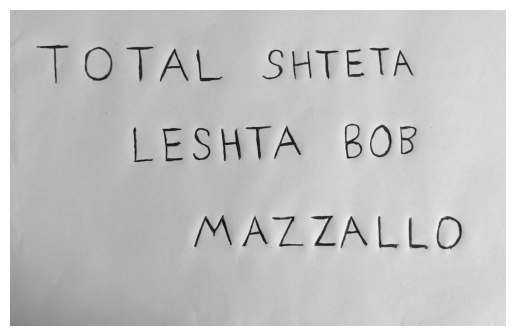

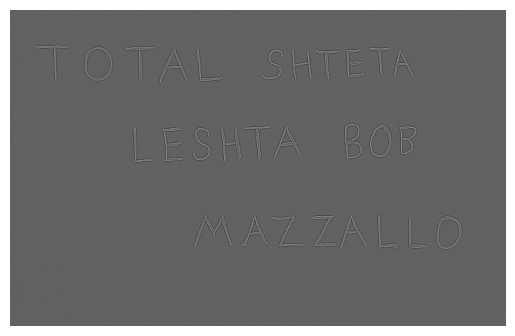

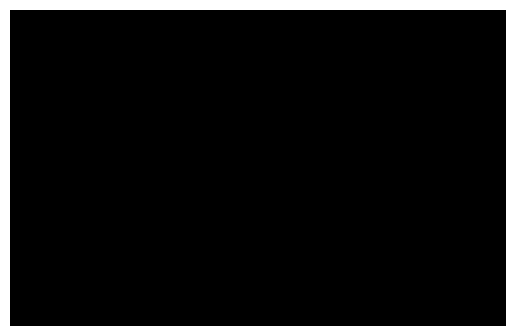

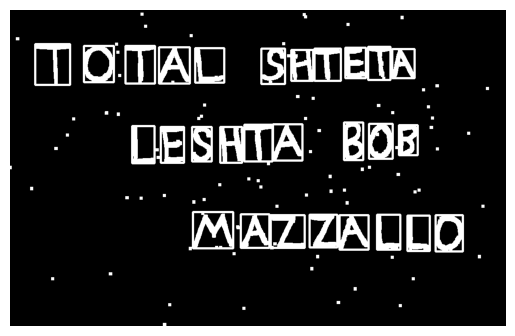

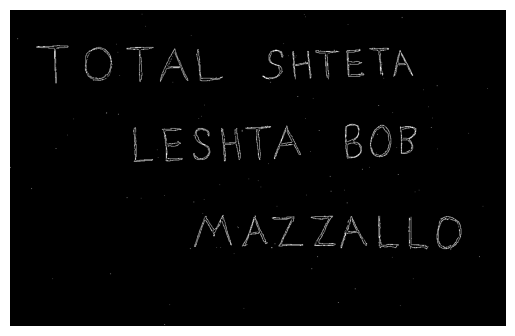

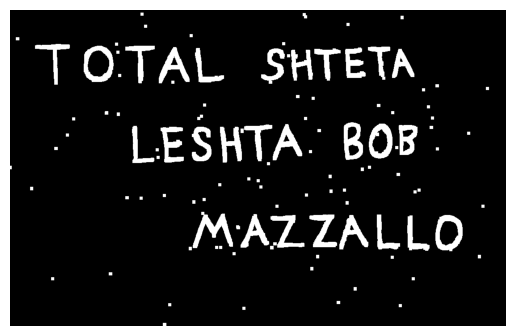

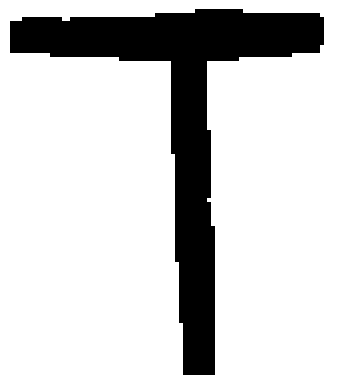

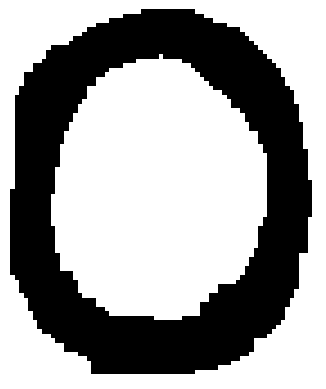

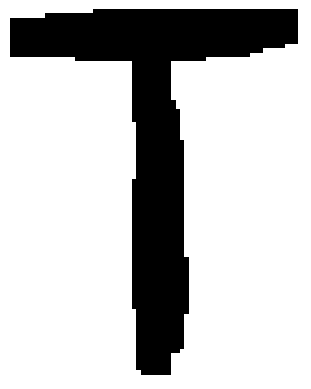

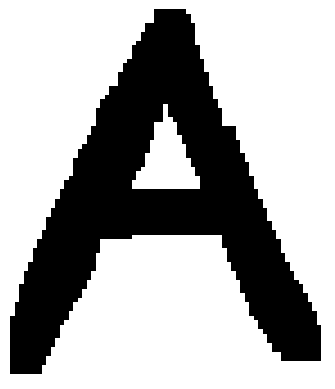

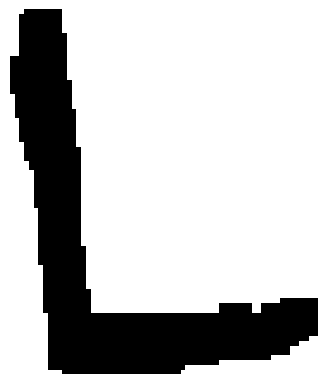

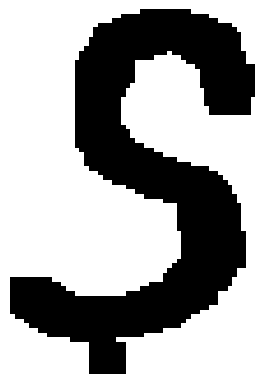

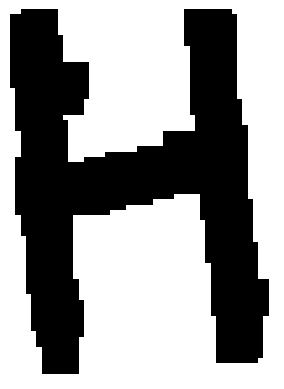

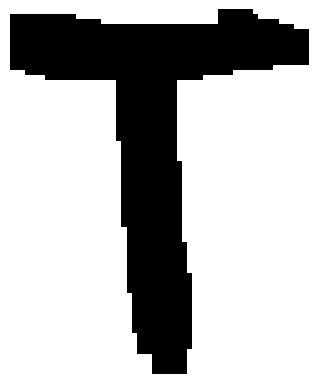

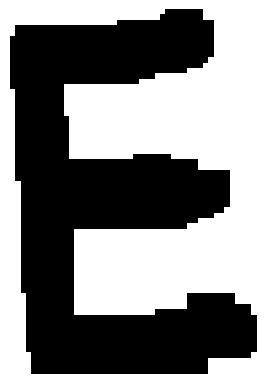

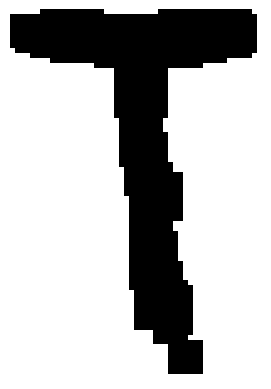

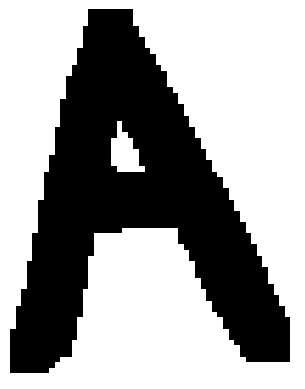

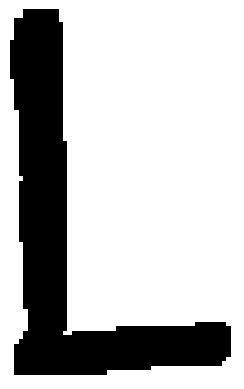

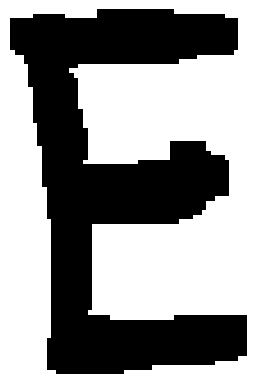

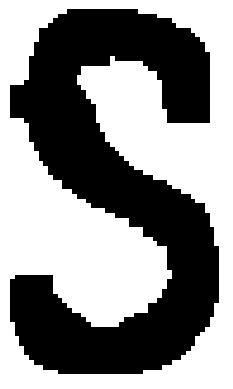

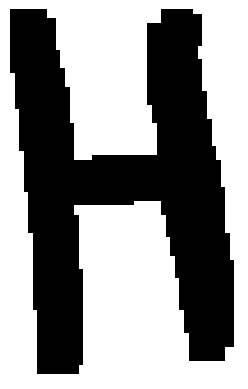

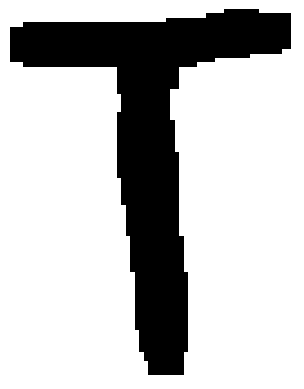

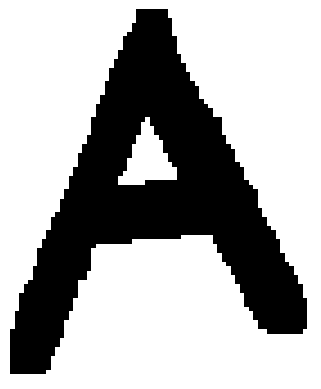

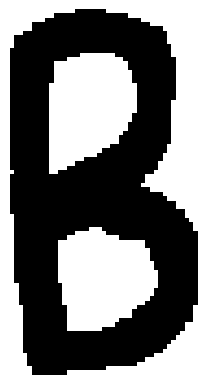

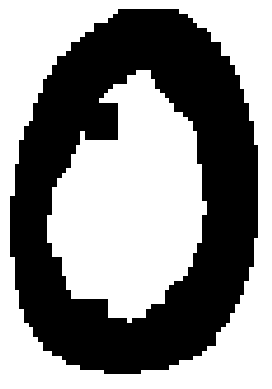

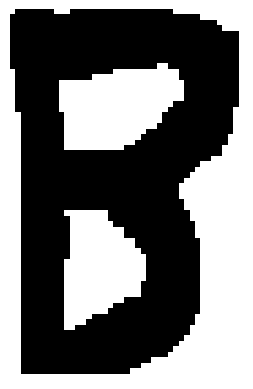

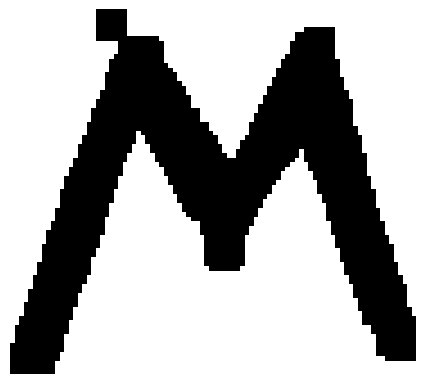

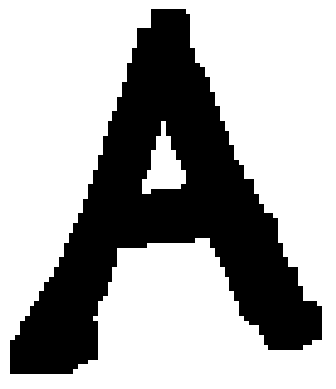

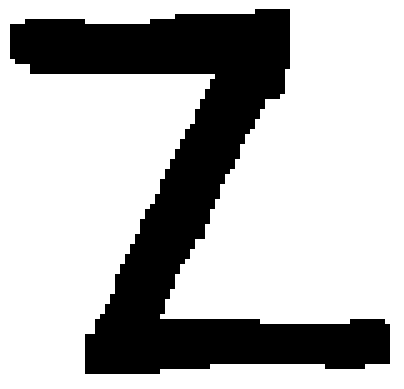

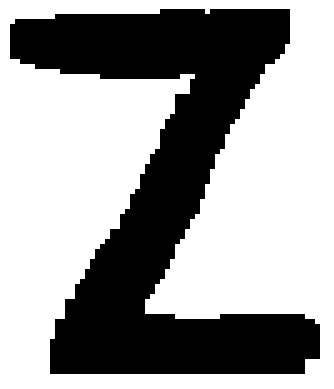

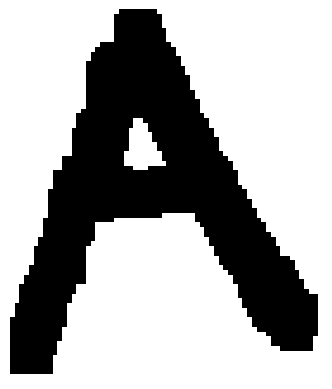

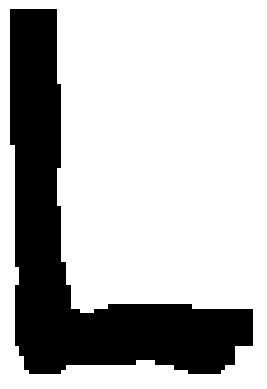

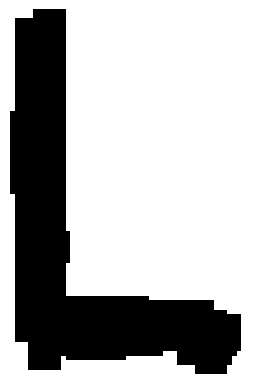

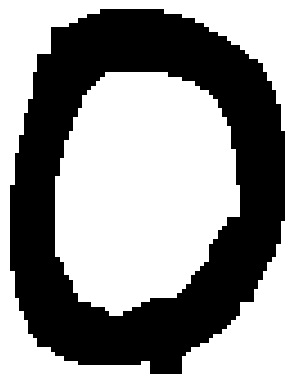

TOTAL SHTETA
LESHTA BOB
MAZZALLO


In [49]:
r = ocr_nn('mazalo.mpng', show_steps=True)
print(r)

In [47]:
r = ocr_nn('multiline.mpng')
print(r)

FMI
INAGE
PROGESSING


In [48]:
r = ocr_nn('multiline-2.mpng')
print(r)

TACTICAL
DIGYTAL
